In [2]:
%%time
%reset -f

import pandas as pd
from rdkit.Chem import AllChem, Draw, Descriptors   
from rdkit import Chem, DataStructs
from rdkit.Avalon.pyAvalonTools import GetAvalonFP
from rdkit.Chem import rdMolDescriptors
from rdkit.DataStructs import ExplicitBitVect

curcumin_variants = (
    "COc3cc(OC)c(C/C=C/C2=CC(/C=C/Cc1c(OC)cc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1c(OC)cc(OC)cc1OC)=C2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "COc5ccc(C/C=C/C4=[O+][B-](F)(F)OC(/C=C/Cc2c1ccccc1cc3ccccc23)=C4)cc5",
    "COc3ccc(OC)c(C/C=C/C2=CC(/C=C/Cc1cc(OC)ccc1OC)=[O+][B-](F)(F)O2)c3",
    "COc3cc(C/C=C/C2=CC(/C=C/Cc1ccc(O)c(OC)c1)=[O+][B-](F)(F)O2)ccc3O",
    "CN(C)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "N#Cc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccccc1)=C2)cc3",
    "COc6ccc(C/C=C/C5=CC(/C=C/Cc1cc2ccc3cccc4ccc(c1)c2c34)=[O+][B-](F)(F)O5)cc6",
    "COc4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(OC)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "CN(C)c4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(N(C)C)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "N#Cc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C#N)cc1)=[O+][B-](F)(F)O2)cc3",
    "CCCCN(CCCC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(CCCC)CCCC)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C#N)cc1)=[O+][B-](F)(F)O2)cc3",
    "CN5/C(=C\C\C=C\C3=CC(/C=C/C/C=C/2N(C)c1ccccc1C2(C)C)=[O+][B-](F)(F)O3)C(C)(C)c4ccccc45",
    "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccc(SC)cc1)=C2)cc3",
    "CSc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(SC)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc1ccccc1C/C=C/C3=CC(/C=C/Cc2ccccc2OC)=[O+][B-](F)(F)O3",
    "CCCCCC(CC)c5ccc(c4ccc(C/C=C/C3=CC(/C=C/Cc2ccc(c1ccc(C(CC)CCCCC)s1)s2)=[O+][B-](F)(F)O3)s4)s5"
)

molecule_names = ['2-ADMeO3', '3-MR83a', 'AD-10', 'AD-1013', 'AD-1022', 'AD-11', 'AD-14-Moore', 'AD-16-DMF', 'AD-18', 'AD-24', 'AD-25', 'AD-3', 'AD-35', 'AD-4', 'AD-48', 'AD-5', 'AD-6', 'AD-7', 'AD-9', 'YD-30']
homo_lumo_gap = [3.077, 3.072, 3.259, 2.625, 2.938, 2.946, 2.811, 3.231, 2.735, 2.878, 2.686, 3.215, 2.77, 3.001, 2.702, 2.97, 2.89, 2.859, 3.137, 2.525]

molecules = [Chem.MolFromSmiles(smiles) for smiles in curcumin_variants]
mws = [round(Descriptors.MolWt(mol),3) for mol in molecules]
logp = [Descriptors.MolLogP(mol) for mol in molecules]

# Create the initial DataFrame of Curcumin
data = {
    'Molecule': molecule_names,
    'Molecular Weight': mws,
    'LogP': logp,
    'Homo-Lumo Gap (eV)': homo_lumo_gap,
    'Smiles': curcumin_variants
}
curcumin_df = pd.DataFrame(data)

def generate_morgan_fingerprint_safe(smiles):
    """Generate Morgan fingerprint and handle errors gracefully."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))
    except Exception:
        return None
    return None

# apply morgan fingerprint to the curcumin_df dataframe
curcumin_df['Morgan_Fingerprints'] = curcumin_df['Smiles'].apply(generate_morgan_fingerprint_safe)
curcumin_df = curcumin_df[curcumin_df['Morgan_Fingerprints'].notnull()].reset_index(drop=True)
morgan_df = pd.DataFrame(curcumin_df['Morgan_Fingerprints'].tolist(), columns=[f'morgan_{i}' for i in range(2048)])

curcumin_df_mf = pd.concat([curcumin_df.drop(columns=['Morgan_Fingerprints']), morgan_df], axis=1)

# Convert any fingerprint to a bit vector
def convert_to_bit_vector(fp, nBits=2048):
    bit_vector = ExplicitBitVect(nBits)
    for bit in fp.GetNonzeroElements().keys():
        bit_vector.SetBit(bit % nBits)
    return bit_vector

# Atom pair Fingerprint bit vector conversion
def generate_atom_pair_fingerprint(mol, nBits=2048):
    fp = rdMolDescriptors.GetAtomPairFingerprint(mol)
    return convert_to_bit_vector(fp, nBits)

# Function to generate fingerprints
def generate_fingerprint(mol, fp_type, radius=2, n_bits=2048):
    if fp_type == 'morgan':
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits, useChirality=True)
    elif fp_type == 'fcfp':
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=n_bits, useChirality=True)
    elif fp_type == 'atom_pair':
        return generate_atom_pair_fingerprint(mol, nBits=n_bits)

# Similarity functions
def calculate_similarity(fp1, fp2, metric):
    if metric == 'tanimoto':
        return DataStructs.TanimotoSimilarity(fp1, fp2)
    elif metric == 'dice':
        return DataStructs.DiceSimilarity(fp1, fp2)
    elif metric == 'cosine':
        return DataStructs.CosineSimilarity(fp1, fp2)
    elif metric == 'kulczynski':
        return DataStructs.KulczynskiSimilarity(fp1, fp2)

curcumin_similarity_variants = {
    "seg01" : "Cc2ccc(/C=C/C(=O)CC(=O)/C=C/c1ccc(C)cc1)cc2",
    "seg02" : "C/C=C/C(=O)CC(=O)/C=C/c1ccc(C)cc1",
    "seg03" : "C/C=C/C(=O)CC(=O)/C=C/C",
    "seg04" : "Cc1ccc(/C=C/C=O)cc1",
    "seg05" : "C/C=C/C=O",
    "seg06" : "C/C=C/C1=CC(/C=C/C)=[O+][B-](F)(F)O1",
}

# Harvard OPV dataset import
data = pd.read_csv('https://raw.githubusercontent.com/AjStephan/havard-smile-opv/main/Non-fullerene%20small-molecules%20acceptors.csv')
opv_df = data.drop(columns=['index', 'inchikey',  'HOMO_calc', 'LUMO_calc', 'LUMO_calib',
       'LUMO_calib_stds', 'HOMO_calib', 'HOMO_calib_stds', 'molW',
       'PCE_calc', 'Voc_calc', 'Jsc_calc', 'FF_calc', 'EQE_calc',
       'PCE_calib', 'Voc_calib', 'Jsc_calib', 'FF_calib', 'EQE_calib',
       'PCE_cdiff', 'PCE_calib_plus'], axis=1)

opv_df["mol"] = opv_df["smiles"].apply(Chem.MolFromSmiles)

# Dictionary to hold the dataframes
similarity_dfs = {}

# Fingerprints and similarity methods
fingerprints = ['morgan', 'atom_pair']
similarities = ['tanimoto', 'cosine', 'kulczynski', 'dice']

# Loop over curcumin segments, fingerprints, and similarities
for key, smiles in curcumin_similarity_variants.items():
    specific_mol = Chem.MolFromSmiles(smiles)
    
    for fp_type in fingerprints:
        specific_fp = generate_fingerprint(specific_mol, fp_type)
        
        for sim_metric in similarities:
            opv_df_sim_segment = opv_df.copy()
            opv_df_sim_segment[f'similarity_{key}_{fp_type}_{sim_metric}'] = opv_df_sim_segment['mol'].apply(lambda x: calculate_similarity(generate_fingerprint(x, fp_type), specific_fp, sim_metric))
            
            # Filter top 48% similar molecules
            quantile_value = opv_df_sim_segment[f'similarity_{key}_{fp_type}_{sim_metric}'].quantile(0.70)
            opv_df_sim_segment = opv_df_sim_segment[opv_df_sim_segment[f'similarity_{key}_{fp_type}_{sim_metric}'] >= quantile_value]
            
            # Keep only the relevant columns (initial columns + similarity)
            opv_df_sim_segment = opv_df_sim_segment[['smiles', 'mol', 'GAP_calib', f'similarity_{key}_{fp_type}_{sim_metric}']]
            
            # Store the filtered dataframe in the dictionary
            similarity_dfs[f'{key}_{fp_type}_{sim_metric}'] = opv_df_sim_segment

            print(f"Generated dataframe for segment {key}, fingerprint {fp_type}, similarity {sim_metric}: shape {opv_df_sim_segment.shape}")

Generated dataframe for segment seg01, fingerprint morgan, similarity tanimoto: shape (15398, 4)
Generated dataframe for segment seg01, fingerprint morgan, similarity cosine: shape (15449, 4)
Generated dataframe for segment seg01, fingerprint morgan, similarity kulczynski: shape (15422, 4)
Generated dataframe for segment seg01, fingerprint morgan, similarity dice: shape (15398, 4)
Generated dataframe for segment seg01, fingerprint atom_pair, similarity tanimoto: shape (15621, 4)
Generated dataframe for segment seg01, fingerprint atom_pair, similarity cosine: shape (15543, 4)
Generated dataframe for segment seg01, fingerprint atom_pair, similarity kulczynski: shape (15377, 4)
Generated dataframe for segment seg01, fingerprint atom_pair, similarity dice: shape (15621, 4)
Generated dataframe for segment seg02, fingerprint morgan, similarity tanimoto: shape (15602, 4)
Generated dataframe for segment seg02, fingerprint morgan, similarity cosine: shape (15407, 4)
Generated dataframe for segm

In [3]:
%%time
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolDescriptors

# Function to generate Morgan fingerprints safely
def generate_morgan_fingerprint_safe(smiles):
    """Generate Morgan fingerprint and handle errors gracefully."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))
    except Exception as e:
        print(f"Error generating Morgan fingerprint for SMILES {smiles}: {e}")
        return None
    return None

# Dictionary to store processed dataframes
processed_similarity_dfs = {}

# Process each dataframe
for combination, df in similarity_dfs.items():
    print(f"Processing {combination}...")
    
    # Make sure df is a copy, not a slice, to avoid the warning
    df = df.copy()

    # Generate Morgan fingerprints
    df['Morgan_Fingerprints'] = df['smiles'].apply(generate_morgan_fingerprint_safe)
    df = df[df['Morgan_Fingerprints'].notnull()].reset_index(drop=True)
    
    # Convert Morgan fingerprints to a DataFrame and concatenate with the original
    morgan_df = pd.DataFrame(df['Morgan_Fingerprints'].tolist(), columns=[f'morgan_{i}' for i in range(2048)])

    df_combined = pd.concat([df.drop(columns=['Morgan_Fingerprints']), morgan_df], axis=1)
    
    # Store the combined DataFrame
    processed_similarity_dfs[combination] = df_combined
    print(f"Finished processing {combination} - shape {df_combined.shape}")

# Unpacking the dictionary to individual DataFrames
for combination, df in processed_similarity_dfs.items():
    globals()[f'similarity_dfs_{combination}'] = df

Processing seg01_morgan_tanimoto...
Finished processing seg01_morgan_tanimoto - shape (15398, 2052)
Processing seg01_morgan_cosine...
Finished processing seg01_morgan_cosine - shape (15449, 2052)
Processing seg01_morgan_kulczynski...
Finished processing seg01_morgan_kulczynski - shape (15422, 2052)
Processing seg01_morgan_dice...
Finished processing seg01_morgan_dice - shape (15398, 2052)
Processing seg01_atom_pair_tanimoto...
Finished processing seg01_atom_pair_tanimoto - shape (15621, 2052)
Processing seg01_atom_pair_cosine...
Finished processing seg01_atom_pair_cosine - shape (15543, 2052)
Processing seg01_atom_pair_kulczynski...
Finished processing seg01_atom_pair_kulczynski - shape (15377, 2052)
Processing seg01_atom_pair_dice...
Finished processing seg01_atom_pair_dice - shape (15621, 2052)
Processing seg02_morgan_tanimoto...
Finished processing seg02_morgan_tanimoto - shape (15602, 2052)
Processing seg02_morgan_cosine...
Finished processing seg02_morgan_cosine - shape (15407, 20

In [4]:
processed_similarity_dfs.keys()

dict_keys(['seg01_morgan_tanimoto', 'seg01_morgan_cosine', 'seg01_morgan_kulczynski', 'seg01_morgan_dice', 'seg01_atom_pair_tanimoto', 'seg01_atom_pair_cosine', 'seg01_atom_pair_kulczynski', 'seg01_atom_pair_dice', 'seg02_morgan_tanimoto', 'seg02_morgan_cosine', 'seg02_morgan_kulczynski', 'seg02_morgan_dice', 'seg02_atom_pair_tanimoto', 'seg02_atom_pair_cosine', 'seg02_atom_pair_kulczynski', 'seg02_atom_pair_dice', 'seg03_morgan_tanimoto', 'seg03_morgan_cosine', 'seg03_morgan_kulczynski', 'seg03_morgan_dice', 'seg03_atom_pair_tanimoto', 'seg03_atom_pair_cosine', 'seg03_atom_pair_kulczynski', 'seg03_atom_pair_dice', 'seg04_morgan_tanimoto', 'seg04_morgan_cosine', 'seg04_morgan_kulczynski', 'seg04_morgan_dice', 'seg04_atom_pair_tanimoto', 'seg04_atom_pair_cosine', 'seg04_atom_pair_kulczynski', 'seg04_atom_pair_dice', 'seg05_morgan_tanimoto', 'seg05_morgan_cosine', 'seg05_morgan_kulczynski', 'seg05_morgan_dice', 'seg05_atom_pair_tanimoto', 'seg05_atom_pair_cosine', 'seg05_atom_pair_kulczy

In [7]:
%%time
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import lightgbm as lgb
import math

# Mappings for segments, fingerprint types, and similarity methods
segment_map = {
    'seg01': 'Segment 01',
    'seg02': 'Segment 02',
    'seg03': 'Segment 03',
    'seg04': 'Segment 04',
    'seg05': 'Segment 05',
    "seg06" : "Segment 06",
}

fingerprint_map = {
    'morgan': 'Morgan Fingerprint',
    'atom_pair': 'Atom Pair Fingerprint'
}

similarity_map = {
    'tanimoto': 'Tanimoto Similarity',
    'cosine': 'Cosine Similarity',
    'kulczynski': 'Kulczynski Similarity',
    'dice': 'Dice Similarity'
}

# Initialize a list to store results
results = []

# Process each dataframe from the global namespace
for combination, df in processed_similarity_dfs.items():
    print(f"Processing {combination}...")
    
    # Extract features (X) and target (y)
    X = df.iloc[:, 4:]  # Assuming the first 4 columns are non-feature columns
    y = df['GAP_calib']  # Target variable
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)
    
    # Initialize and train the LightGBM model
    tuned_params = {'n_estimators': 1000, 'learning_rate': 0.23685145356420312, 'num_leaves': 51}
    model = lgb.LGBMRegressor(**tuned_params)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate R^2 scores and RMSE
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = math.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = math.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # Extracting segment, fingerprint type, and similarity method from the combination name
    parts = combination.split('_')  # Split the combination string into parts
    
    # Handle the case where the fingerprint type is 'atom_pair'
    if '_'.join(parts[1:3]) == 'atom_pair':
        segment_key = parts[0]  # Assuming the segment is the first part
        fingerprint_type_key = '_'.join(parts[1:3])  # Join parts to get 'atom_pair'
        similarity_method_key = parts[3]  # Similarity method is the fourth part
    else:
        segment_key = parts[0]  # Assuming the segment is the first part
        fingerprint_type_key = parts[1]  # Fingerprint type is the second part
        similarity_method_key = parts[2]  # Similarity method is the third part
    
    # Map the keys to human-readable names using the mappings
    segment_name = segment_map.get(segment_key, segment_key)
    fingerprint_name = fingerprint_map.get(fingerprint_type_key, fingerprint_type_key)
    similarity_name = similarity_map.get(similarity_method_key, similarity_method_key)
    
    # Store results in the list
    results.append({
        'Segment': segment_name,
        'Fingerprint Type': fingerprint_name,
        'Similarity Method': similarity_name,
        'Train R2 Score': train_r2,
        'Test R2 Score': test_r2,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse
    })
    
    print(f"Done processing {combination} with Test R^2 score: {test_r2} and Test RMSE: {test_rmse}")

# Convert results to a DataFrame for further analysis
final_results = pd.DataFrame(results)

# Save the results to a CSV file for further use
final_results.to_csv(path_or_buf=r"C:\Users\Chamod Peiris\Documents\Curcumin_Scripts\Phase03.csv")

# Display the first few rows of the results
final_results.head()

Processing seg01_morgan_tanimoto...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2342
[LightGBM] [Info] Number of data points in the train set: 11548, number of used features: 1171
[LightGBM] [Info] Start training from score 2.877134
Done processing seg01_morgan_tanimoto with Test R^2 score: 0.9170366372707716 and Test RMSE: 0.17167720872970774
Processing seg01_morgan_cosine...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2336
[LightGBM] [Info] Number of data points in the train set: 11586, number of used features: 1168
[LightGBM] [Info] Start training from score 2.824746
D

,Segment,Fingerprint Type,Similarity Method,Train R2 Score,Test R2 Score,Train RMSE,Test RMSE
0,Segment 01,Morgan Fingerprint,Tanimoto Similarity,0.995490,0.917037,0.041905,0.171677
1,Segment 01,Morgan Fingerprint,Cosine Similarity,0.995105,0.928905,0.042025,0.158311
2,Segment 01,Morgan Fingerprint,Kulczynski Similarity,0.994906,0.925638,0.041543,0.159406
3,Segment 01,Morgan Fingerprint,dice,0.995490,0.917037,0.041905,0.171677
4,Segment 01,Atom Pair Fingerprint,Tanimoto Similarity,0.996082,0.945269,0.035371,0.131461


In [8]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

# Load the results from the CSV file
final_results = pd.read_csv(r"C:\Users\Chamod Peiris\Documents\Curcumin_Scripts\Phase03.csv")

# Calculate the absolute variance between Train and Test R² scores
final_results['Variance'] = abs(final_results['Train R2 Score'] - final_results['Test R2 Score'])

# Create six plots, one for each segment
for segment in final_results['Segment'].unique():
    # Filter data for the current segment
    segment_data = final_results[final_results['Segment'] == segment]
    
    # Identify the best model (highest Test R² score)
    best_model = segment_data.loc[segment_data['Test R2 Score'].idxmax()]
    
    # Create a grouped bar plot for Train and Test R² scores
    fig = go.Figure()
    
    # Add bars for Train R² scores
    fig.add_trace(go.Bar(
        x=segment_data['Fingerprint Type'] + ' - ' + segment_data['Similarity Method'],
        y=segment_data['Train R2 Score'],
        name='Train R² Score',
        marker_color='blue',
        text=segment_data['Train R2 Score'].round(4),
        textposition='auto'
    ))
    
    # Add bars for Test R² scores
    fig.add_trace(go.Bar(
        x=segment_data['Fingerprint Type'] + ' - ' + segment_data['Similarity Method'],
        y=segment_data['Test R2 Score'],
        name='Test R² Score',
        marker_color='orange',
        text=segment_data['Test R2 Score'].round(4),
        textposition='auto'
    ))
    
    # Add a line for the absolute variance (secondary y-axis)
    fig.add_trace(go.Scatter(
        x=segment_data['Fingerprint Type'] + ' - ' + segment_data['Similarity Method'],
        y=segment_data['Variance'],
        mode='lines+markers',
        name='Absolute Variance',
        yaxis='y2',
        line=dict(color='red', dash='dash')
    ))
    
    # Update layout to include secondary y-axis
    fig.update_layout(
        title=f'R² Scores and Variance for {segment}',
        xaxis_title='Fingerprint Type - Similarity Method',
        yaxis_title='R² Score',
        yaxis2=dict(
            title='Absolute Variance',
            overlaying='y',
            side='right',
            showgrid=False,
            zeroline=False
        ),
        barmode='group',
        legend=dict(x=0.85, y=1.0),
        width=1000,
        height=600
    )
    
    # Add annotation for the best model
    fig.add_annotation(
        x=best_model['Fingerprint Type'] + ' - ' + best_model['Similarity Method'],
        y=best_model['Test R2 Score'],
        text=f"Best Model:<br>Test R²={best_model['Test R2 Score']:.4f}<br>{best_model['Fingerprint Type']} - {best_model['Similarity Method']}",
        showarrow=True,
        arrowhead=3,
        ax=0,
        ay=-50,
        font=dict(color="black", size=12),
        bgcolor="silver"
    )

    # legend orientation
    fig.update_layout(
    legend=dict(
        orientation='h',  # Horizontal orientation
        yanchor='bottom',
        y=1.01,  # Position above the plot
        xanchor='center',
        x=0.5  # Center horizontally
    )
)
    
    # Show the plot
    fig.show()

In [9]:
import pandas as pd
import plotly.graph_objects as go

# Load the results from the CSV file
final_results = pd.read_csv(r"C:\Users\Chamod Peiris\Documents\Curcumin_Scripts\Phase03.csv")

# Calculate the absolute variance between Train and Test R² scores
final_results['Variance'] = abs(final_results['Train R2 Score'] - final_results['Test R2 Score'])

# Initialize an empty DataFrame to store the best models from all segments
best_models_all_segments = pd.DataFrame()

# Process each segment to find the best model
for segment in final_results['Segment'].unique():
    # Filter data for the current segment
    segment_data = final_results[final_results['Segment'] == segment]
    
    # Identify the best model (highest Test R² score)
    best_model = segment_data.loc[segment_data['Test R2 Score'].idxmax()]
    
    # Append to the DataFrame of best models
    best_models_all_segments = best_models_all_segments.append(best_model, ignore_index=True)

# Create a grouped bar plot for Train and Test R² scores of the best models
fig = go.Figure()

# Add bars for Train R² scores
fig.add_trace(go.Bar(
    x=best_models_all_segments['Segment'] + ' - ' + best_models_all_segments['Fingerprint Type'] + ' - ' + best_models_all_segments['Similarity Method'],
    y=best_models_all_segments['Train R2 Score'],
    name='Train R² Score',
    marker_color='blue',
    text=best_models_all_segments['Train R2 Score'].round(4),
    textposition='auto'
))

# Add bars for Test R² scores
fig.add_trace(go.Bar(
    x=best_models_all_segments['Segment'] + ' - ' + best_models_all_segments['Fingerprint Type'] + ' - ' + best_models_all_segments['Similarity Method'],
    y=best_models_all_segments['Test R2 Score'],
    name='Test R² Score',
    marker_color='orange',
    text=best_models_all_segments['Test R2 Score'].round(4),
    textposition='auto'
))

# Add a line for the absolute variance (secondary y-axis)
fig.add_trace(go.Scatter(
    x=best_models_all_segments['Segment'] + ' - ' + best_models_all_segments['Fingerprint Type'] + ' - ' + best_models_all_segments['Similarity Method'],
    y=best_models_all_segments['Variance'],
    mode='lines+markers',
    name='Absolute Variance',
    yaxis='y2',
    line=dict(color='red', dash='dash')
))

# Update layout to include secondary y-axis
fig.update_layout(
    title='Best Models Across All Segments',
    xaxis_title='Model',
    yaxis_title='R² Score',
    yaxis2=dict(
        title='Absolute Variance',
        overlaying='y',
        side='right',
        showgrid=False,
        zeroline=False
    ),
    barmode='group',
    legend=dict(x=0.85, y=1.0),
    width=1000,
    height=600
)

# Add annotation for the best model
# Note: For a single annotation, you may need to specify manually or use another method to highlight specific points.

# legend orientation
fig.update_layout(
    legend=dict(
        orientation='h',  # Horizontal orientation
        yanchor='bottom',
        y=1.01,  # Position above the plot
        xanchor='center',
        x=0.5  # Center horizontally
    )
)

# Show the plot
fig.show()

C:\Users\Chamod Peiris\AppData\Local\Temp\ipykernel_5248\2427960453.py:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2172
[LightGBM] [Info] Number of data points in the train set: 11715, number of used features: 1086
[LightGBM] [Info] Start training from score 2.640914
___________________________________________________________________
Model similarity_dfs_seg01_atom_pair_tanimoto R2 Score: 0.9452694549902021 & RMSE value: 0.13146063017554127
Prediction with similarity_dfs_seg01_atom_pair_tanimoto model R2 Score: -0.9637375167000959 & RMSE value: 0.0808691214255117
___________________________________________________________________


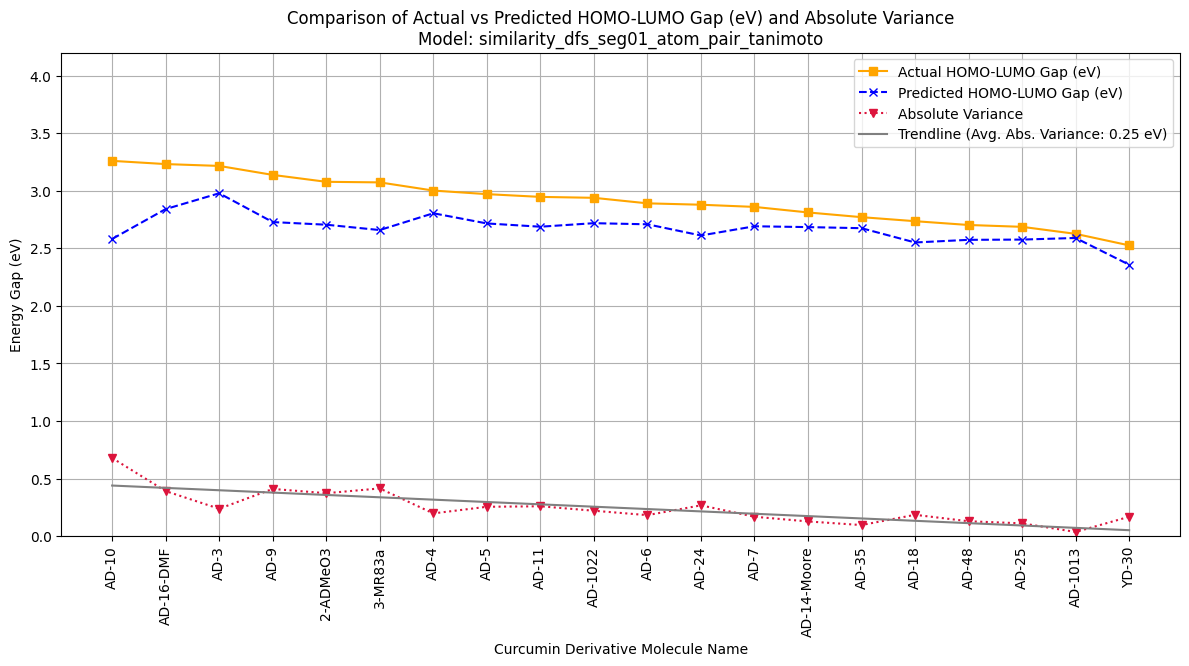

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2258
[LightGBM] [Info] Number of data points in the train set: 11884, number of used features: 1129
[LightGBM] [Info] Start training from score 2.753275
___________________________________________________________________
Model similarity_dfs_seg02_atom_pair_tanimoto R2 Score: 0.949256437337211 & RMSE value: 0.13851110790581278
Prediction with similarity_dfs_seg02_atom_pair_tanimoto model R2 Score: -1.2558574911748668 & RMSE value: 0.09289898055165141
___________________________________________________________________


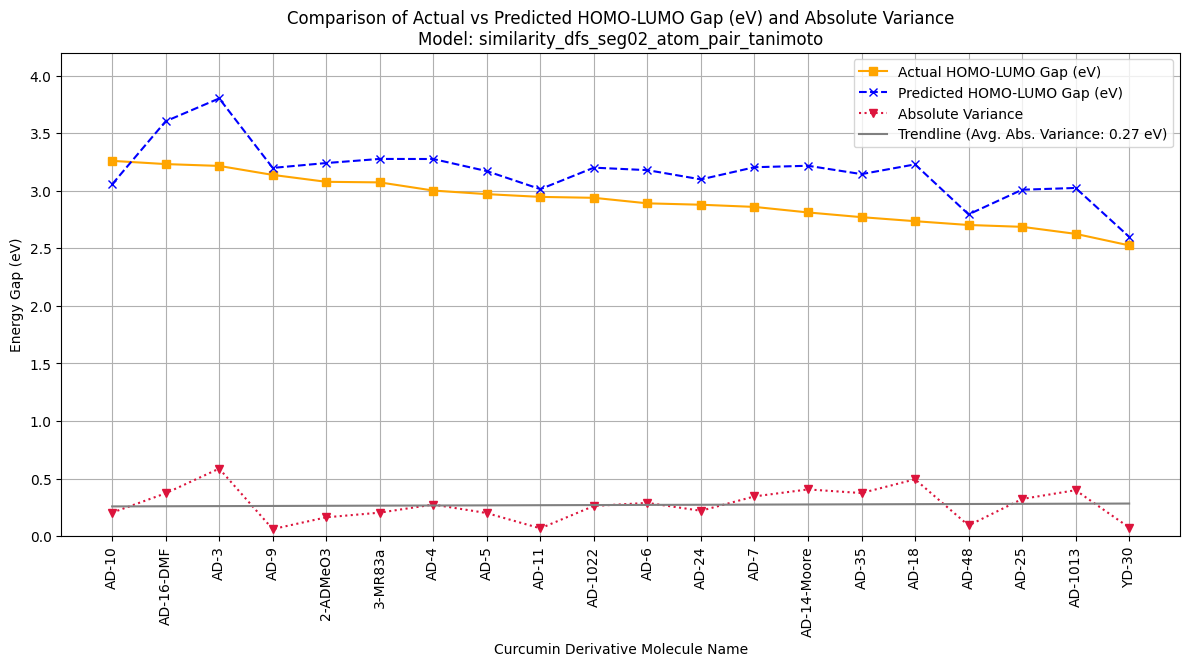

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 11603, number of used features: 1111
[LightGBM] [Info] Start training from score 2.779224
___________________________________________________________________
Model similarity_dfs_seg03_atom_pair_tanimoto R2 Score: 0.9497734857508109 & RMSE value: 0.14190812295894353
Prediction with similarity_dfs_seg03_atom_pair_tanimoto model R2 Score: -1.7329883122965515 & RMSE value: 0.11254781344352531
___________________________________________________________________


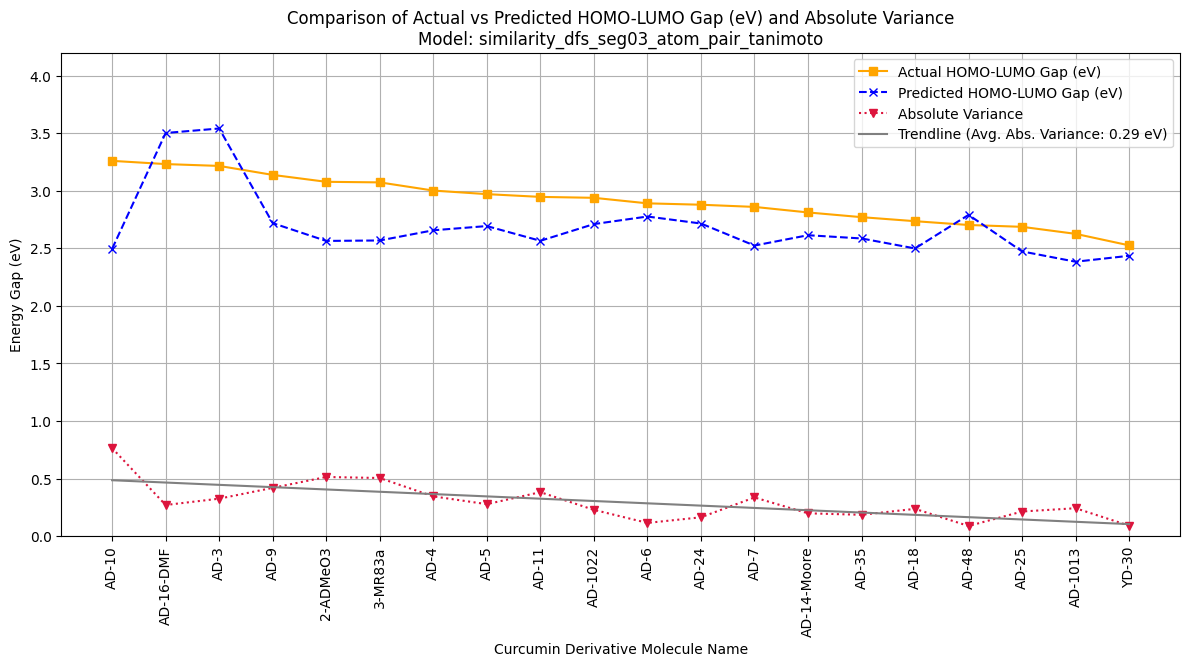

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2180
[LightGBM] [Info] Number of data points in the train set: 11760, number of used features: 1090
[LightGBM] [Info] Start training from score 2.604945
___________________________________________________________________
Model similarity_dfs_seg04_morgan_kulczynski R2 Score: 0.9449937947854098 & RMSE value: 0.1291021791994623
Prediction with similarity_dfs_seg04_morgan_kulczynski model R2 Score: -5.627863280796664 & RMSE value: 0.27294354560538375
___________________________________________________________________


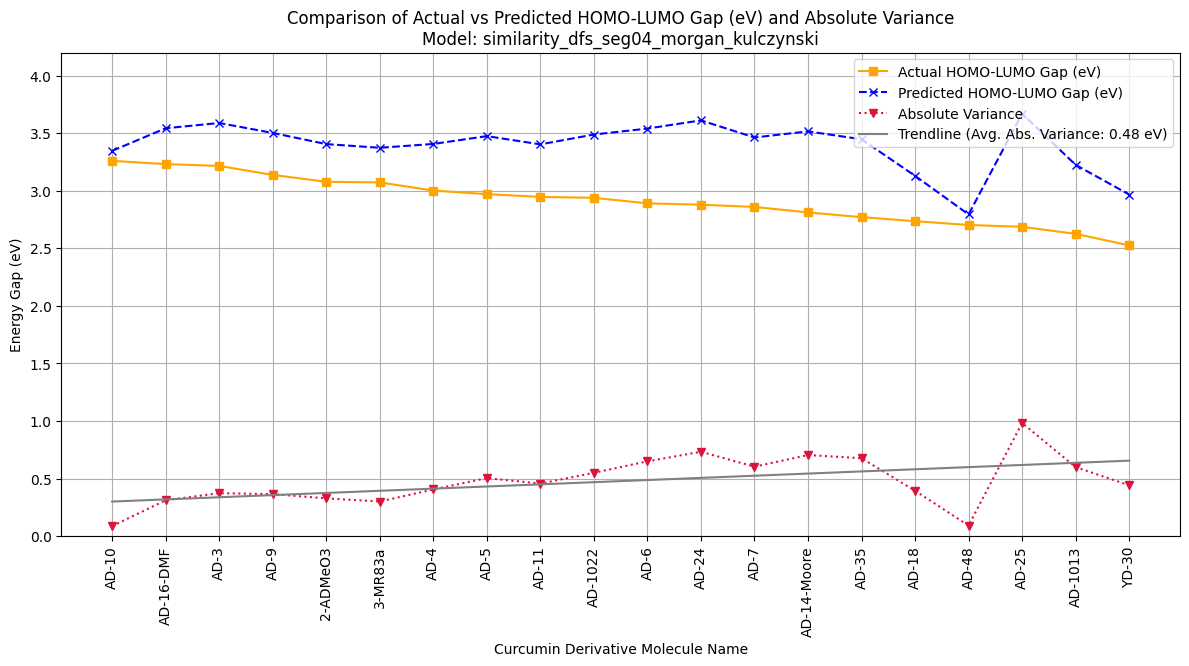

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2184
[LightGBM] [Info] Number of data points in the train set: 11573, number of used features: 1092
[LightGBM] [Info] Start training from score 2.777741
___________________________________________________________________
Model similarity_dfs_seg05_atom_pair_tanimoto R2 Score: 0.9502441477797716 & RMSE value: 0.14418581173458364
Prediction with similarity_dfs_seg05_atom_pair_tanimoto model R2 Score: -0.07092990799338095 & RMSE value: 0.044102208177629484
___________________________________________________________________


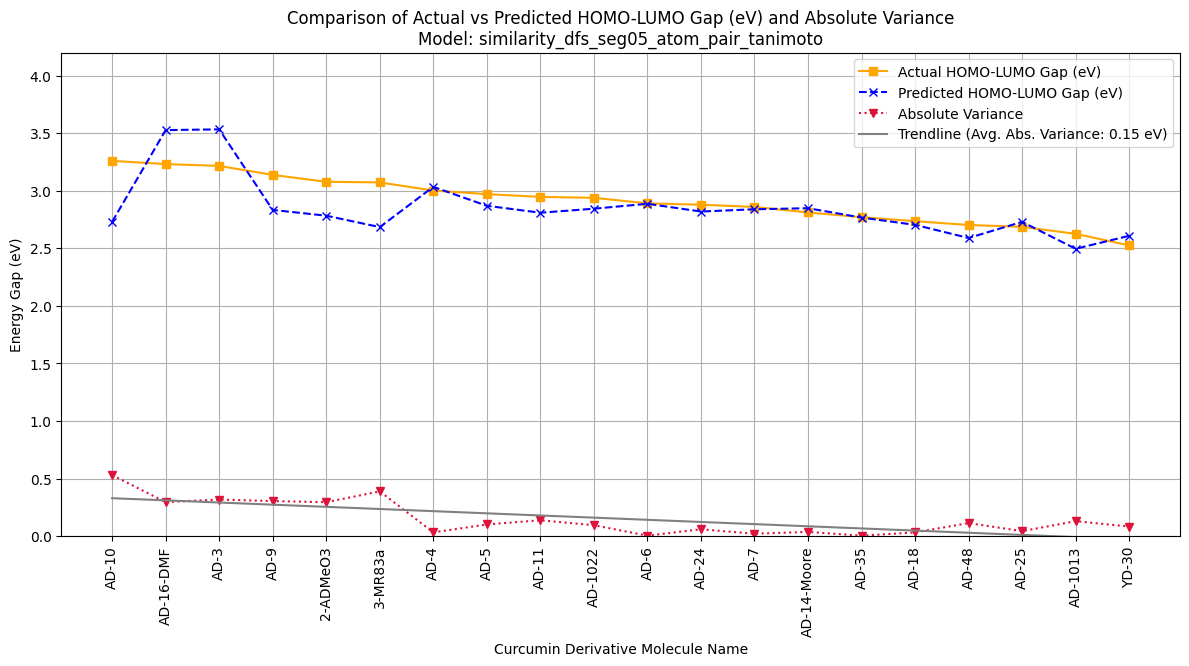

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2176
[LightGBM] [Info] Number of data points in the train set: 11551, number of used features: 1088
[LightGBM] [Info] Start training from score 2.760670
___________________________________________________________________
Model similarity_dfs_seg06_atom_pair_tanimoto R2 Score: 0.9485334122384518 & RMSE value: 0.14469537597313378
Prediction with similarity_dfs_seg06_atom_pair_tanimoto model R2 Score: -0.19558826821329656 & RMSE value: 0.04923579246962277
___________________________________________________________________


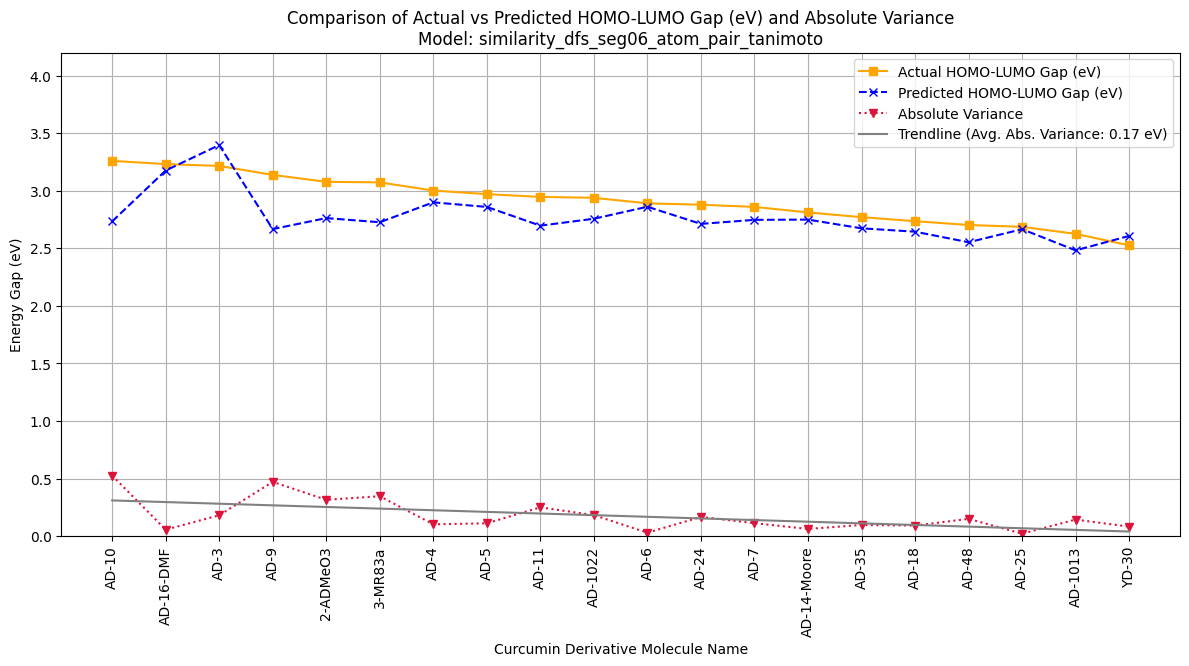

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import lightgbm as lgb

# List of the best model dataframes
best_models_all_segments = ["similarity_dfs_seg01_atom_pair_tanimoto",
                            "similarity_dfs_seg02_atom_pair_tanimoto", 
                            "similarity_dfs_seg03_atom_pair_tanimoto", 
                            "similarity_dfs_seg04_morgan_kulczynski", 
                            "similarity_dfs_seg05_atom_pair_tanimoto",
                            "similarity_dfs_seg06_atom_pair_tanimoto"]

# Iterate through the list of best models
for model_name in best_models_all_segments:
    # Dynamically reference the corresponding dataframe
    model_df = globals()[model_name]
    
    x = model_df.iloc[:, 4:]
    y = model_df['GAP_calib']
    
    # Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=123)
    
    # Initialize and train the LightGBM model
    tuned_params = {'n_estimators': 1000, 'learning_rate': 0.23685145356420312, 'num_leaves': 51}
    model = lgb.LGBMRegressor(**tuned_params)
    model.fit(x_train, y_train)
    
    # Make predictions and calculate R^2 score
    y_pred = model.predict(x_test)
    
    # Calculate R2 score and RMSE for the model
    r2_model = r2_score(y_test, y_pred)
    rmse_model = mean_squared_error(y_test, y_pred, squared=False)
    
    curcumin_df_mf_pred = curcumin_df_mf.copy()
    curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'] = model.predict(curcumin_df_mf.iloc[:, 5:])
    
    r2_predict = r2_score(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])
    rmse_predict = mean_squared_error(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])
    
    print("___________________________________________________________________")
    print(f"Model {model_name} R2 Score: {r2_model} & RMSE value: {rmse_model}")
    print(f"Prediction with {model_name} model R2 Score: {r2_predict} & RMSE value: {rmse_predict}")   
    print("___________________________________________________________________")
    
    # Sort curcumin_df_mf_pred by 'Homo-Lumo Gap (eV)' in descending order and reset the index
    curcumin_df_mf_pred = curcumin_df_mf_pred.sort_values(by='Homo-Lumo Gap (eV)', ascending=False).reset_index(drop=True)
    
    # Calculate the absolute variance between 'Homo-Lumo Gap (eV)' and 'Homo-Lumo Gap (eV) Pred'
    curcumin_df_mf_pred['absolute_variance'] = (curcumin_df_mf_pred['Homo-Lumo Gap (eV)'] - curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred']).abs()
    
    # Calculate linear trendline for absolute variance
    x_vals = curcumin_df_mf_pred.index
    y_vals = curcumin_df_mf_pred['absolute_variance']
    coefficients = np.polyfit(x_vals, y_vals, 1)  # Fit a linear polynomial
    trendline = np.polyval(coefficients, x_vals)
    
    # Calculate the average absolute variance
    average_variance = y_vals.mean()
    
    # Plotting the actual vs predicted energy gaps
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot the actual values
    ax1.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], marker='s', label='Actual HOMO-LUMO Gap (eV)', color='orange')
    
    # Plot the predicted values
    ax1.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'], marker='x', linestyle='--', label='Predicted HOMO-LUMO Gap (eV)', color='blue')
    
    # Plot the absolute variance as a dotted line
    ax1.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['absolute_variance'], marker='v', linestyle=':', label='Absolute Variance', color='crimson')
    
    # Plot the trendline for absolute variance
    ax1.plot(curcumin_df_mf_pred['Molecule'], trendline, linestyle='-', color='grey', label=f'Trendline (Avg. Abs. Variance: {average_variance:.2f} eV)')
    
    # Set labels for the axes and the range
    ax1.set_xlabel('Curcumin Derivative Molecule Name')
    ax1.set_ylabel('Energy Gap (eV)')
    ax1.set_ylim([0, 4.2])  # Adjust the y-axis range as needed
    ax1.tick_params(axis='y')
    ax1.legend(loc='upper right')
    
    # Customize the plot
    plt.title(f'Comparison of Actual vs Predicted HOMO-LUMO Gap (eV) and Absolute Variance\nModel: {model_name}')
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=90)
    
    # Show the plot
    plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2172
[LightGBM] [Info] Number of data points in the train set: 11715, number of used features: 1086
[LightGBM] [Info] Start training from score 2.640914
___________________________________________________________________
Model similarity_dfs_seg01_atom_pair_tanimoto R2 Score: 0.9452694549902021 & RMSE value: 0.13146063017554127
Prediction with similarity_dfs_seg01_atom_pair_tanimoto model R2 Score: -0.9637375167000959 & RMSE value: 0.0808691214255117
___________________________________________________________________


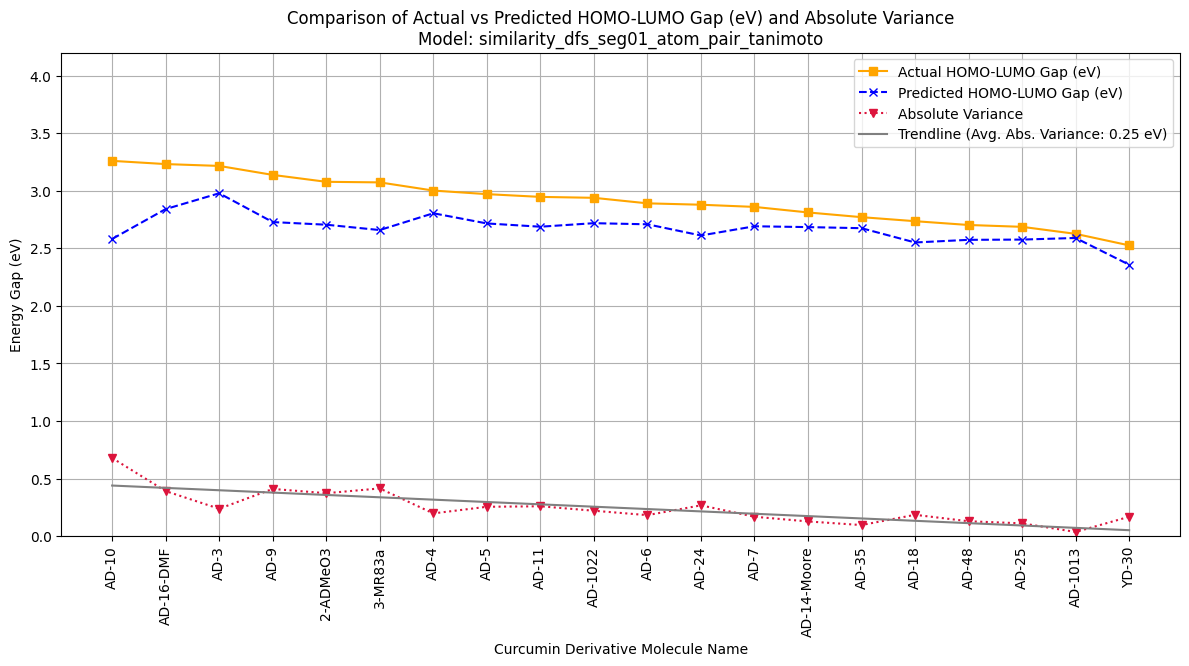

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2258
[LightGBM] [Info] Number of data points in the train set: 11884, number of used features: 1129
[LightGBM] [Info] Start training from score 2.753275
___________________________________________________________________
Model similarity_dfs_seg02_atom_pair_tanimoto R2 Score: 0.949256437337211 & RMSE value: 0.13851110790581278
Prediction with similarity_dfs_seg02_atom_pair_tanimoto model R2 Score: -1.2558574911748668 & RMSE value: 0.09289898055165141
___________________________________________________________________


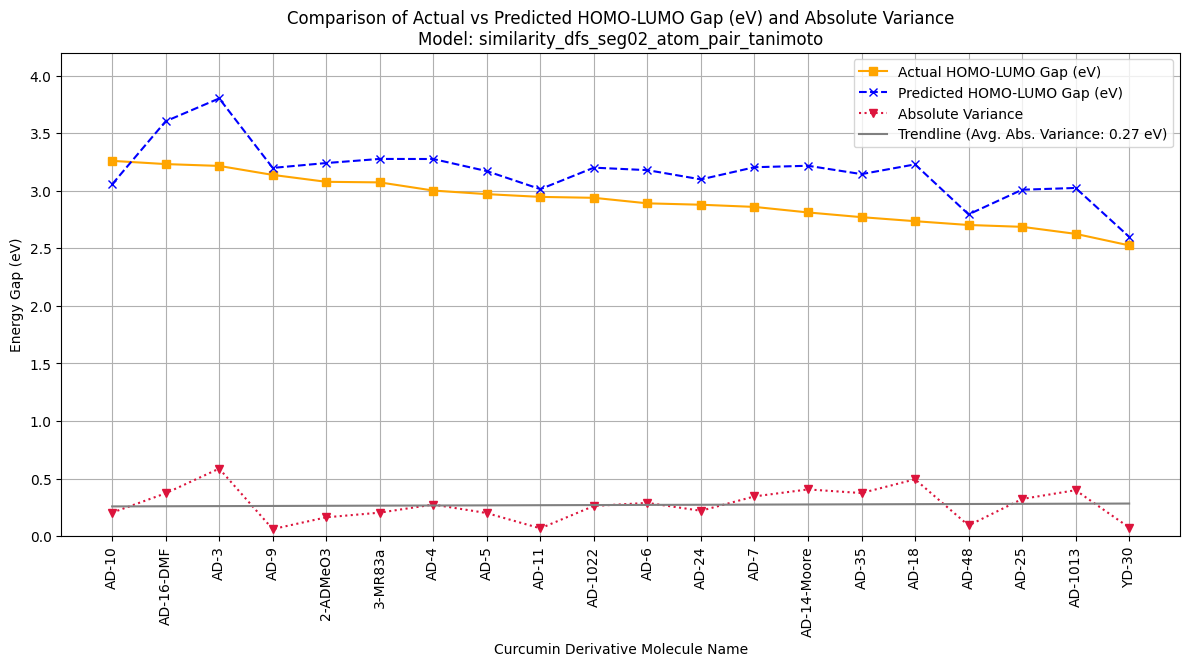

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 11603, number of used features: 1111
[LightGBM] [Info] Start training from score 2.779224
___________________________________________________________________
Model similarity_dfs_seg03_atom_pair_tanimoto R2 Score: 0.9497734857508109 & RMSE value: 0.14190812295894353
Prediction with similarity_dfs_seg03_atom_pair_tanimoto model R2 Score: -1.7329883122965515 & RMSE value: 0.11254781344352531
___________________________________________________________________


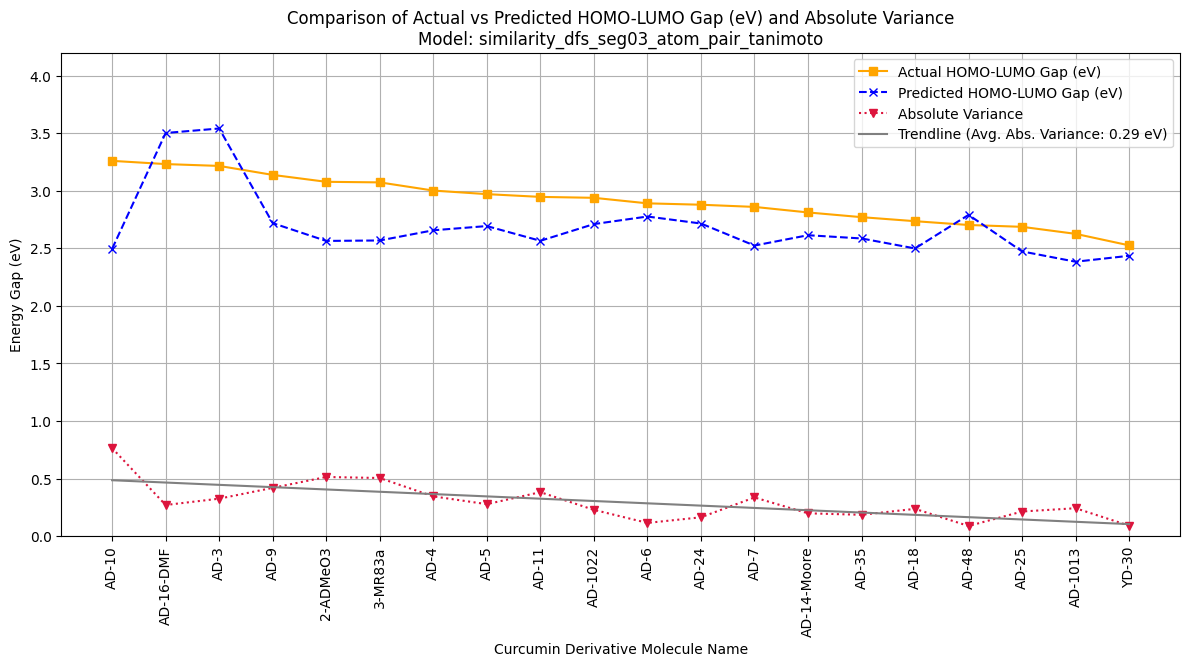

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2180
[LightGBM] [Info] Number of data points in the train set: 11760, number of used features: 1090
[LightGBM] [Info] Start training from score 2.604945
___________________________________________________________________
Model similarity_dfs_seg04_morgan_kulczynski R2 Score: 0.9449937947854098 & RMSE value: 0.1291021791994623
Prediction with similarity_dfs_seg04_morgan_kulczynski model R2 Score: -5.627863280796664 & RMSE value: 0.27294354560538375
___________________________________________________________________


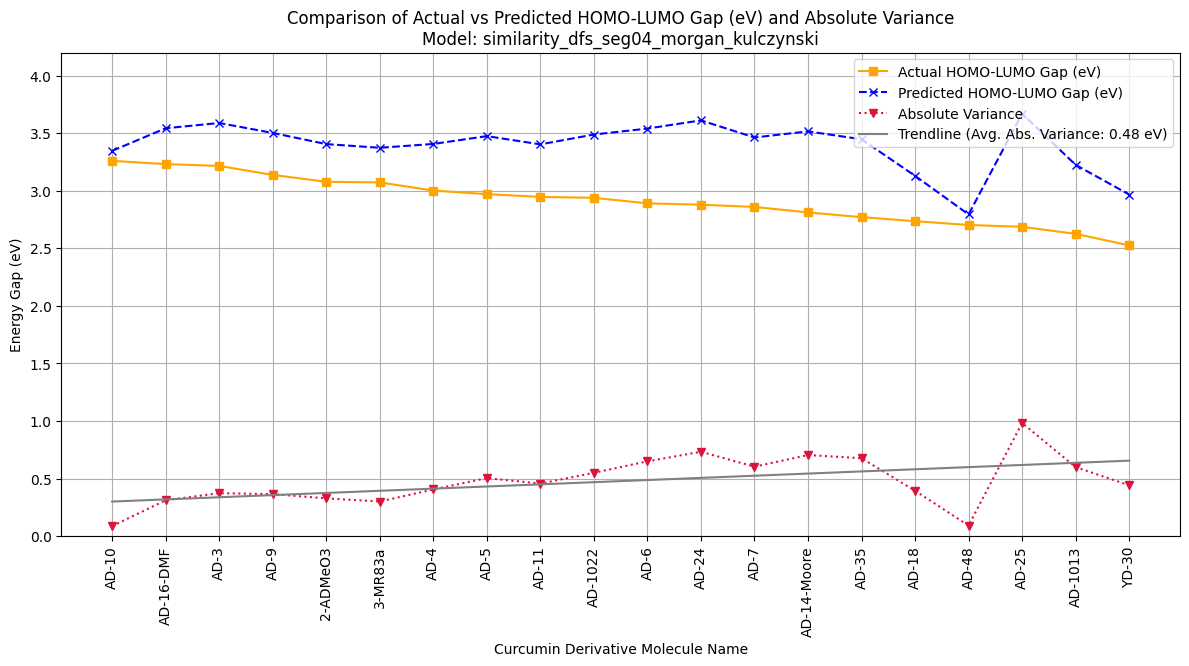

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2184
[LightGBM] [Info] Number of data points in the train set: 11573, number of used features: 1092
[LightGBM] [Info] Start training from score 2.777741
___________________________________________________________________
Model similarity_dfs_seg05_atom_pair_tanimoto R2 Score: 0.9502441477797716 & RMSE value: 0.14418581173458364
Prediction with similarity_dfs_seg05_atom_pair_tanimoto model R2 Score: -0.07092990799338095 & RMSE value: 0.044102208177629484
___________________________________________________________________


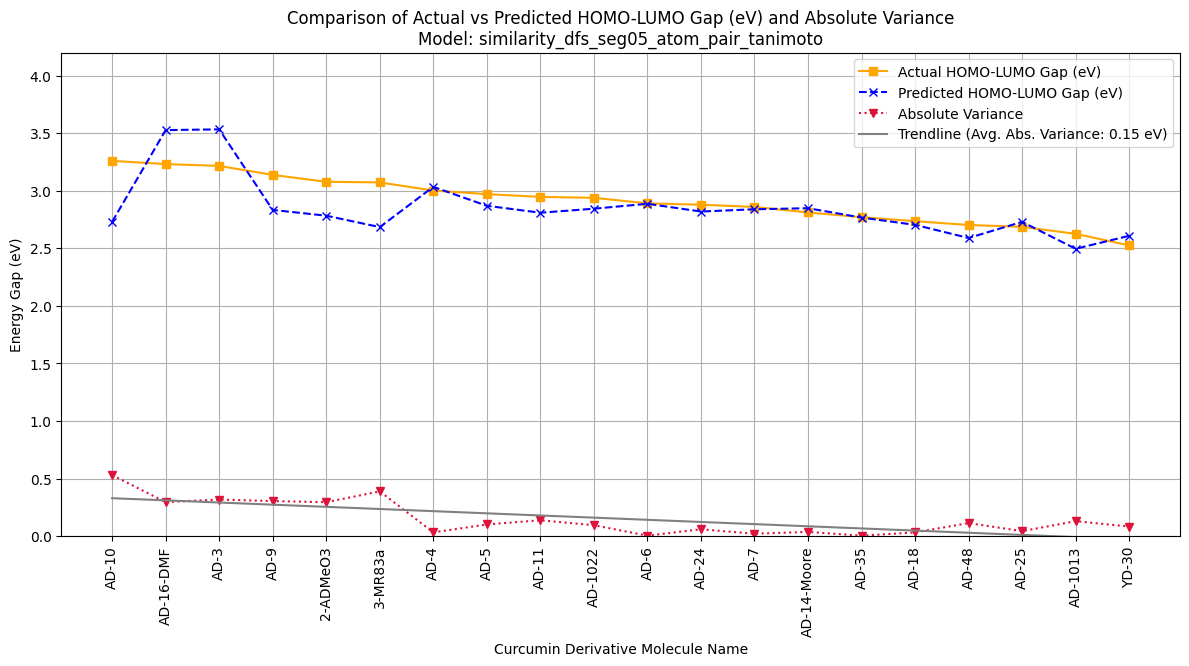

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2176
[LightGBM] [Info] Number of data points in the train set: 11551, number of used features: 1088
[LightGBM] [Info] Start training from score 2.760670
___________________________________________________________________
Model similarity_dfs_seg06_atom_pair_tanimoto R2 Score: 0.9485334122384518 & RMSE value: 0.14469537597313378
Prediction with similarity_dfs_seg06_atom_pair_tanimoto model R2 Score: -0.19558826821329656 & RMSE value: 0.04923579246962277
___________________________________________________________________


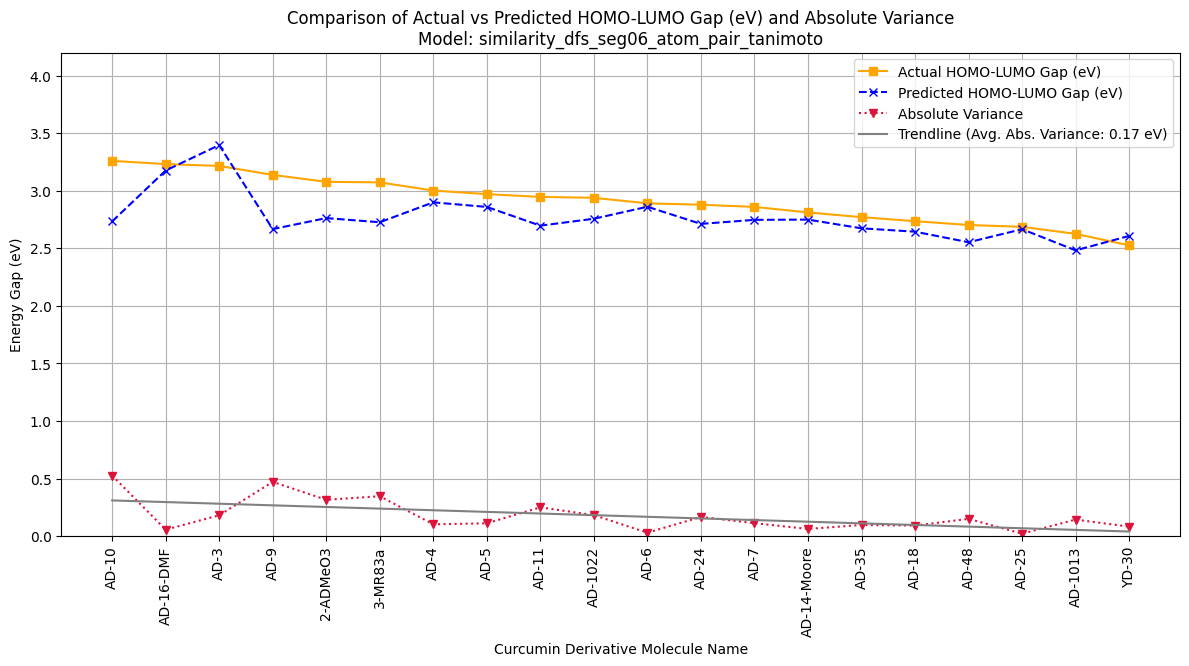

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import lightgbm as lgb

# List of the best model dataframes
best_models_all_segments = ["similarity_dfs_seg01_atom_pair_tanimoto",
                            "similarity_dfs_seg02_atom_pair_tanimoto", 
                            "similarity_dfs_seg03_atom_pair_tanimoto", 
                            "similarity_dfs_seg04_morgan_kulczynski", 
                            "similarity_dfs_seg05_atom_pair_tanimoto",
                            "similarity_dfs_seg06_atom_pair_tanimoto"
                            ]

# Iterate through the list of best models
for model_name in best_models_all_segments:
    # Dynamically reference the corresponding dataframe
    model_df = globals()[model_name]
    
    x = model_df.iloc[:, 4:]
    y = model_df['GAP_calib']
    
    # Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=123)
    
    # Initialize and train the LightGBM model
    tuned_params = {'n_estimators': 1000, 'learning_rate': 0.23685145356420312, 'num_leaves': 51}
    model = lgb.LGBMRegressor(**tuned_params)
    model.fit(x_train, y_train)
    
    # Make predictions and calculate R^2 score
    y_pred = model.predict(x_test)
    
    # Calculate R2 score and RMSE for the model
    r2_model = r2_score(y_test, y_pred)
    rmse_model = mean_squared_error(y_test, y_pred, squared=False)
    
    curcumin_df_mf_pred = curcumin_df_mf.copy()
    curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'] = model.predict(curcumin_df_mf.iloc[:, 5:])
    
    r2_predict = r2_score(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])
    rmse_predict = mean_squared_error(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])
    
    print("___________________________________________________________________")
    print(f"Model {model_name} R2 Score: {r2_model} & RMSE value: {rmse_model}")
    print(f"Prediction with {model_name} model R2 Score: {r2_predict} & RMSE value: {rmse_predict}")   
    print("___________________________________________________________________")
    
    # Sort curcumin_df_mf_pred by 'Homo-Lumo Gap (eV)' in descending order and reset the index
    curcumin_df_mf_pred = curcumin_df_mf_pred.sort_values(by='Homo-Lumo Gap (eV)', ascending=False).reset_index(drop=True)
    
    # Calculate the absolute variance between 'Homo-Lumo Gap (eV)' and 'Homo-Lumo Gap (eV) Pred'
    curcumin_df_mf_pred['absolute_variance'] = (curcumin_df_mf_pred['Homo-Lumo Gap (eV)'] - curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred']).abs()
    
    # Calculate linear trendline for absolute variance
    x_vals = curcumin_df_mf_pred.index
    y_vals = curcumin_df_mf_pred['absolute_variance']
    coefficients = np.polyfit(x_vals, y_vals, 1)  # Fit a linear polynomial
    trendline = np.polyval(coefficients, x_vals)
    
    # Calculate the average absolute variance
    average_variance = y_vals.mean()
    
    # Plotting the actual vs predicted energy gaps
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot the actual values
    ax1.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], marker='s', label='Actual HOMO-LUMO Gap (eV)', color='orange')
    
    # Plot the predicted values
    ax1.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'], marker='x', linestyle='--', label='Predicted HOMO-LUMO Gap (eV)', color='blue')
    
    # Plot the absolute variance as a dotted line
    ax1.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['absolute_variance'], marker='v', linestyle=':', label='Absolute Variance', color='crimson')
    
    # Plot the trendline for absolute variance
    ax1.plot(curcumin_df_mf_pred['Molecule'], trendline, linestyle='-', color='grey', label=f'Trendline (Avg. Abs. Variance: {average_variance:.2f} eV)')
    
    # Set labels for the axes and the range
    ax1.set_xlabel('Curcumin Derivative Molecule Name')
    ax1.set_ylabel('Energy Gap (eV)')
    ax1.set_ylim([0, 4.2])  # Adjust the y-axis range as needed
    ax1.tick_params(axis='y')
    ax1.legend(loc='upper right')
    
    # Customize the plot
    plt.title(f'Comparison of Actual vs Predicted HOMO-LUMO Gap (eV) and Absolute Variance\nModel: {model_name}')
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=90)
    
    # Show the plot
    plt.show()